In [1]:
import pandas as pd
import numpy as np
import os

# Data preprocessing

In [48]:
full_df = pd.read_csv('preprocessed_wmt21_news_data.tsv', sep='\t')

In [49]:
def delete_tags(row): 
    return row.replace('<v>', '').replace('</v>', '')

In [50]:
full_df['mt_output'] = full_df.target.apply(lambda s: delete_tags(s))

#### Compute z-normalization

In [52]:
rater_dict = {}
    
for rater in full_df.rater.unique():
    rater_scores = full_df[full_df.rater == rater].mqm_avg_score.values
    rater_dict[rater] = [np.mean(rater_scores), np.std(rater_scores, dtype=np.float64)]
rater_dict

{'rater2': [-4.910228401191659, 6.502035022317828],
 'rater4': [-2.353282588011418, 3.083299012772057],
 'rater11': [-2.792, 3.934048296602369],
 'rater1': [-0.6451866404715128, 1.9735948673915524],
 'rater6': [-1.027019867549669, 1.4201290840974],
 'rater12': [-2.7965354330708663, 3.7744254144670046],
 'rater9': [-3.2061264822134388, 3.5231226626751466],
 'rater7': [-7.195714285714285, 5.717666638707019],
 'rater13': [-5.4484375, 5.59966495056568],
 'rater10': [-2.7927007299270077, 3.5058790048387025],
 'rater8': [-1.1083333333333332, 0.8892490589755431],
 'rater5': [-0.9090909090909091, 1.928473039599675]}

In [53]:
def z_normalize(row):
    mu, sigma = rater_dict[row.rater]
    z_score = (row.mqm_avg_score - mu) / sigma
    return z_score
full_df['z_mqm_score'] = full_df.apply(lambda row: z_normalize(row), axis=1)

In [57]:
full_df.to_csv('wmt21_preprocessed_full_data.tsv', sep='\t', index=False)

#### Randomly select one mt translation per segment_id

In [7]:
seg_ids = full_df.seg_id.unique()
systems = full_df.system_name.unique()

In [8]:
import random

max_num = full_df.system_name.nunique() - 1

mqm_scores = []
mqm_z_scores = []
refs = []
hyps = []
srs = []
sel_systems = []
arr = [0,0,0,0,0,0,0,0,0,0,0,0,0]
for si in seg_ids:
    n = random.randint(0, max_num)
    arr[n] += 1
    sys_name = systems[n]
    sel_row = full_df[(full_df['system_name']==sys_name)&(full_df['seg_id']==si)].iloc[0]
    
    srs.append(sel_row['source'])
    mqm_scores.append(sel_row['mqm_avg_score'])
    mqm_z_scores.append(sel_row['z_mqm_score'])
    refs.append(sel_row['reference'])
    hyps.append(sel_row['mt_output'])
    sel_systems.append(sys_name)

In [9]:
arr

[32, 49, 43, 41, 53, 44, 41, 44, 50, 34, 33, 28, 35]

[Text(0.5, 1.0, 'MQM socres histogram'), Text(0, 0.5, 'MQM scores')]

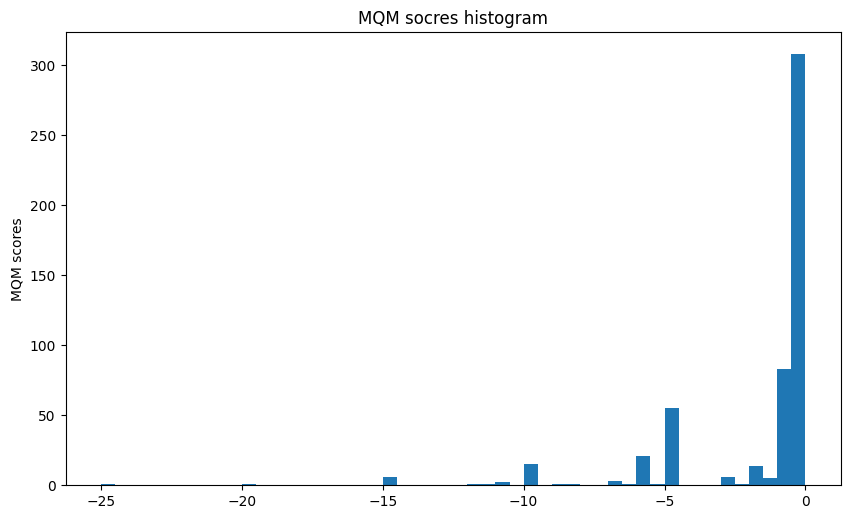

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':100})

# Plot Histogram
plt.hist(mqm_scores, bins=50)
plt.gca().set(title='MQM socres histogram', ylabel='MQM scores')

[Text(0.5, 1.0, 'MQM z-socres histogram'), Text(0, 0.5, 'MQM z-scores')]

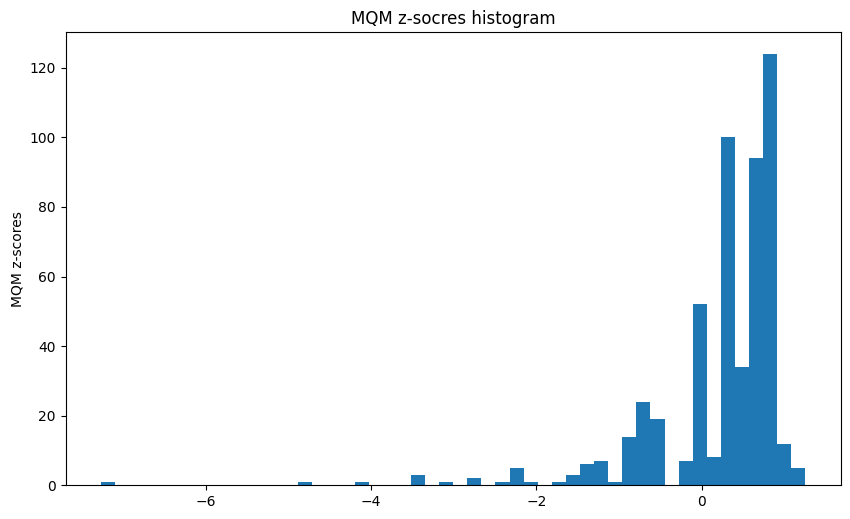

In [11]:
plt.hist(mqm_z_scores, bins=50)
plt.gca().set(title='MQM z-socres histogram', ylabel='MQM z-scores')

In [12]:
with open('mt_output_wmt21_de.txt', 'w') as f:
    f.write('\n'.join(hyps))

with open('referenceC_wmt21_de.txt', 'w') as f:
    f.write('\n'.join(refs))

with open('source_wmt21_en.txt', 'w') as f:
    f.write('\n'.join(srs))

with open('mqm_num_scores_wmt21_en_de.txt', 'w') as f:
    mqm_scores_str = [str(score) for score in mqm_scores]
    f.write('\n'.join(mqm_scores_str))

with open('mqm_z_scores_wmt21_en_de.txt', 'w') as f:
    mqm_z_scores_str = [str(score) for score in mqm_z_scores]
    f.write('\n'.join(mqm_z_scores_str))

---
---

# Data analysis

In [6]:
import pathlib
import os
import pickle
import string

import torch

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
dler = nltk.downloader.Downloader()
dler._update_index()
dler.download('omw-1.4')
# dler.download('all')

[nltk_data] Downloading package punkt to /home/ira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ira/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

__Data__:
- refs : reference translation from ref. systym C
- hyps : MT output
- mqm_scores : mqm numerical scores from wmt21
- mqm_z_scores : normalized mqm scores

In [14]:
def rmv_punkt(s):
    punkt_symbols = string.punctuation
    punkt_symbols += '“'
    for char in punkt_symbols:
        s = s.replace(char, '')
    return s

In [15]:
ref_tokens = [rmv_punkt(s) for s in refs]
ref_tokens = [word_tokenize(s) for s in ref_tokens]

In [16]:
mt_tokens = [rmv_punkt(s) for s in hyps]
mt_tokens = [word_tokenize(s) for s in mt_tokens]

In [17]:
mt_snts = hyps
ref_snts = refs

### Load preprocessed data

In [8]:
import os
import pickle
import pandas as pd
import numpy as np

wmt_data_folder = '../data/wmt21/preprocessed_data'

ref_path = os.path.join(wmt_data_folder, 'all_ref_snts_21.pickle')
mt_path = os.path.join(wmt_data_folder, 'all_mt_snts_21.pickle')
srs_path = os.path.join(wmt_data_folder, 'all_src_snts_21.pickle')
mqm_scores_path = os.path.join(wmt_data_folder, 'all_z_mqm_scores.pickle')
    
with open(ref_path, 'rb') as fp:
    ref_snts = pickle.load(fp)

with open(mt_path, 'rb') as fp:
    mt_snts = pickle.load(fp)

with open(mqm_scores_path, 'rb') as fp:
    human_scores = pickle.load(fp)

with open(srs_path, 'rb') as fp:
    src_snts = pickle.load(fp)
    

In [10]:
precomputed_scores_dir = '../data/precomputed_metric_scores_for_wmt21_all'

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(rc={'figure.figsize':(26, 1)})
sns.set(font_scale=1.6)


## Compute metric scores

In [5]:
# metric_scores = pd.DataFrame(data={'mqm_score': mqm_scores, 'z_mqm_score': human_scores})
metric_scores = pd.DataFrame(data={'z_mqm_score': human_scores})

In [20]:
metric_scores['human_score'] = human_scores

### Metrics from SacreBleu

In [9]:
import sacrebleu as sb

sb_chrf = sb.CHRF()
sb_ter = sb.TER()
sb_bleu = sb.BLEU()

sb_bleu.effective_order = True
metric_scores['sacre_bleu'] = [sb_bleu.sentence_score(mt_snts[i], [ref_snts[i]]).score / 100 for i in range(len(mt_snts))]
metric_scores['sacre_chrf'] = [sb_chrf.sentence_score(mt_snts[i], [ref_snts[i]]).score / 100 for i in range(len(mt_snts))]
metric_scores['sacre_ter'] = [(100 - sb_ter.sentence_score(mt_snts[i], [ref_snts[i]]).score) / 100 for i in range(len(mt_snts))]

metric_scores

,z_mqm_score,sacre_bleu,sacre_chrf,sacre_ter
0,-0.013807,0.310978,0.485126,0.481481
1,-0.858404,0.166685,0.454055,0.444444
2,-1.182732,0.092059,0.408957,0.296296
3,-1.182732,0.092059,0.408957,0.296296
4,-0.561254,0.128462,0.486589,0.407407
...,...,...,...,...
8345,0.342346,0.299924,0.640811,0.615385
8346,0.080083,0.269947,0.538037,0.500000
8347,0.709702,0.299924,0.640811,0.615385
8348,0.326909,0.299924,0.640811,0.615385


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='sacre_bleu'>

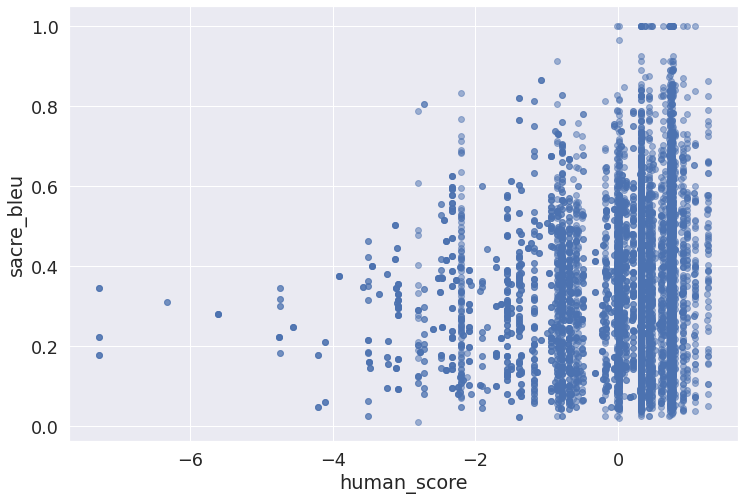

In [27]:
metric_scores.plot.scatter(x='human_score', y='sacre_bleu', alpha=0.5, figsize=(12,8), s=35, )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='sacre_chrf'>

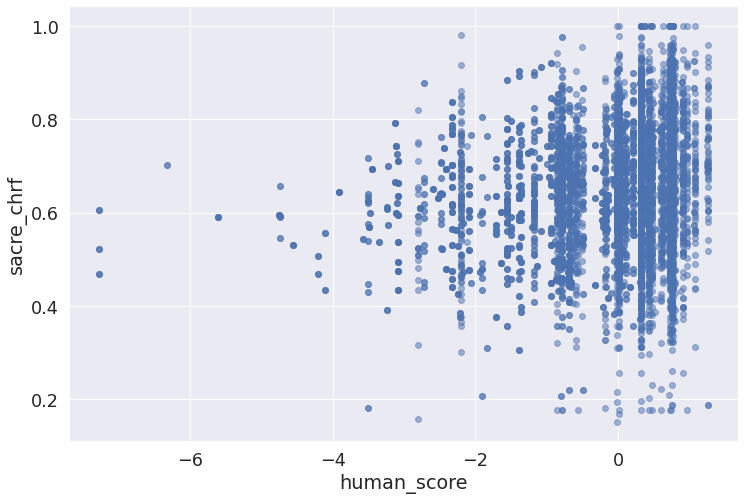

In [28]:
metric_scores.plot.scatter(x='human_score', y='sacre_chrf', alpha=0.5, figsize=(12,8), s=35, )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='sacre_ter'>

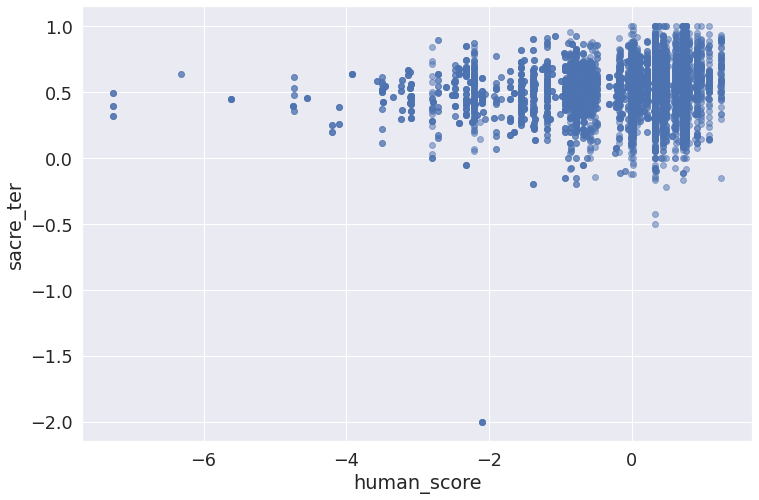

In [29]:
metric_scores.plot.scatter(x='human_score', y='sacre_ter', alpha=0.5, figsize=(12,8), s=35, )

### Metrics from NLTK library

In [20]:
from nltk.translate import meteor_score, bleu_score, chrf_score, nist_score, ribes_score
from nltk.util import ngrams

In [21]:
# METEOR

metric_scores['nltk_meteor'] = [meteor_score.meteor_score([ref_tokens[i]], mt_tokens[i]) for i in range(len(ref_tokens))]

In [22]:
# NIST

metric_scores['nltk_nist'] = [nist_score.sentence_nist([ref_tokens[i]], mt_tokens[i], n=2) for i in range(len(ref_tokens))]

In [23]:
# RIBES

metric_scores['nltk_ribes'] = [ribes_score.sentence_ribes([ref_tokens[i]], mt_tokens[i]) for i in range(len(ref_tokens))]

### HLEPOR 

In [24]:
from hlepor import single_hlepor_score, hlepor_score
metric_scores['hlepor'] = [single_hlepor_score(ref_snts[i], mt_snts[i]) for i in range(len(ref_snts))]

[nltk_data] Downloading package punkt to /home/ira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### BERTScore

In [14]:
# check if model used supported German
bertscore_path = os.path.join(precomputed_scores_dir, 'bert_scores_21_xlm-roberta-large.pickle')
with open(bertscore_path, 'rb') as f:
    bert_scores = pickle.load(f)
metric_scores['bert_xlm-roberta-large_f1'] = bert_scores['F1']

bertscore_path = os.path.join(precomputed_scores_dir, 
                              'bert_scores_no_idf_layer_18_xlm-roberta-large_21.pickle')
with open(bertscore_path, 'rb') as f:
    bert_scores = pickle.load(f)
metric_scores['bert_layer_18_xlm-roberta-large_f1'] = bert_scores['F1']
    
bertscore_path = os.path.join(precomputed_scores_dir, 
                              'bert_scores_with_idf_21_xlm-roberta-large.pickle')
with open(bertscore_path, 'rb') as f:
    bert_scores = pickle.load(f)
metric_scores['bert_with_idf_xlm-roberta-large_f1'] = bert_scores['F1']
    
# with open('bert_f1_scores_wmt21.pickle', 'rb') as f:
#     bert_scores = pickle.load(f)
# metric_scores['bert_deberta_f1'] = bert_scores

In [18]:
metric_scores.corr(method='pearson')

,z_mqm_score,sacre_bleu,sacre_chrf,sacre_ter,bert_xlm-roberta-large_f1,bert_layer_18_xlm-roberta-large_f1,bert_with_idf_xlm-roberta-large_f1
z_mqm_score,1.000000,0.152896,0.179027,0.185955,0.267285,0.270434,0.265106
sacre_bleu,0.152896,1.000000,0.826729,0.829111,0.742709,0.751040,0.725740
sacre_chrf,0.179027,0.826729,1.000000,0.742083,0.800897,0.798561,0.833957
sacre_ter,0.185955,0.829111,0.742083,1.000000,0.772001,0.781108,0.737139
bert_xlm-roberta-large_f1,0.267285,0.742709,0.800897,0.772001,1.000000,0.988814,0.959273
bert_layer_18_xlm-roberta-large_f1,0.270434,0.751040,0.798561,0.781108,0.988814,1.000000,0.956682
bert_with_idf_xlm-roberta-large_f1,0.265106,0.725740,0.833957,0.737139,0.959273,0.956682,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='bert_xlm-roberta-large_f1'>

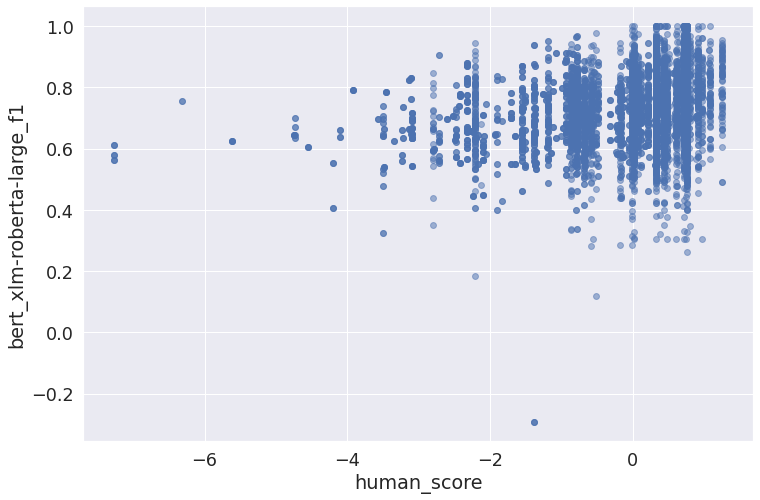

In [30]:
metric_scores.plot.scatter(x='human_score', y='bert_xlm-roberta-large_f1', alpha=0.5, figsize=(12,8), s=35, )

### BLEURT 

In [47]:
bleurt_path = os.path.join(precomputed_scores_dir, 'all_bleurt_scores_wmt21.pickle')

with open(bleurt_path, 'rb') as f:
    bleurt_scores = pickle.load(f)
len(bleurt_scores)

8350

In [48]:
bleurt_scores = np.asarray(bleurt_scores)
metric_scores['bleurt'] = bleurt_scores

# bleurt_mu = np.mean(bleurt_scores)
# bleurt_sigma = np.std(bleurt_scores)

# z_score_f = lambda t: (t - bleurt_mu) / bleurt_sigma
# v_z_score_f = np.vectorize(z_score_f)
# z_bleurt_scores = v_z_score_f(bleurt_scores)
# metric_scores['z_bleurt'] = z_bleurt_scores

### COMET

In [44]:
comet_path = os.path.join(precomputed_scores_dir, 'all_comet_scores_df_21.pickle')
with open(comet_path, 'rb') as f:
    comet_scores_df = pickle.load(f)
comet_scores_df

,z_mqm_scores,comet_reg_da,comet_reg_mqm
0,-0.013807,-0.759673,0.016829
1,-0.858404,-0.765728,0.016492
2,-1.182732,-0.850904,0.015186
3,-1.182732,-0.850904,0.015186
4,-0.561254,-0.931326,0.016496
...,...,...,...
8345,0.342346,0.715877,0.036771
8346,0.080083,-0.314926,0.025257
8347,0.709702,0.715831,0.036779
8348,0.326909,0.715831,0.036779


In [45]:
metric_scores['comet_reg_mqm_21'] = comet_scores_df['comet_reg_mqm']

In [54]:
metric_scores['comet_reg_da_20'] = comet_scores_df['comet_reg_da']

### BEER

In [28]:
with open('beer_scores_wmt21.txt', 'r') as f:
    beer_scores = f.readlines()
beer_scores = [float(s.split(' ')[-1][:-1]) for s in beer_scores[:-1]] # the last line contains total score

In [29]:
metric_scores['beer'] = beer_scores

### PRISM

In [30]:
with open('prism_scores_wmt21.pickle', 'rb') as f:
    prism_scores = pickle.load(f)
metric_scores['prism_ref'] = prism_scores['prism_ref']
metric_scores['prism_src'] = prism_scores['prism_src']

### ROUGE

In [31]:
with open('rouge_wmt21.pickle', 'rb') as f:
    rouge_scores = pickle.load(f)
metric_scores['rouge_1_f1'] = rouge_scores

### GTM

In [32]:
with open('gtm_scores_wmt21.txt', 'r') as f:
    gtm_report = f.readlines()
gtm_scores = []
for l in gtm_report:
    if 'sampledoc' in l:
        scores = l[:-1].split(' ')
        if len(scores) == 3:
            score = float(scores[2])
            gtm_scores.append(score)
metric_scores['gtm'] = gtm_scores

### YISI

### TERp

In [33]:
terp_scores = pd.read_csv("terpa.simple21.seg.scr", sep='\t', header=None, names=['sys_id', 'col', 'doc_id', 'seg_id', 'terp','words_count'])
terp_scores = terp_scores[['terp','words_count']]
terp_scores['words_count'] = terp_scores['words_count'].apply(lambda x: int(x))
terp_scores

,terp,words_count
0,0.720633,27
1,1.000000,18
2,0.675958,41
3,0.572126,36
4,0.878713,43
...,...,...
522,0.678603,66
523,0.674586,48
524,0.323573,33
525,0.651793,40


In [34]:
metric_scores['terp'] = 1 - terp_scores['terp'].values

### MoverScore

In [35]:
with open('mover_scores_wmt21.pickle', 'rb') as f:
    mover_scores = pickle.load(f)
metric_scores['mover_score'] = mover_scores

In [36]:
metric_scores['mover_score'] = metric_scores['mover_score'].apply(lambda x: x[0])
metric_scores

,mqm_score,z_mqm_score,sacre_bleu,sacre_chrf,sacre_ter,nltk_meteor,nltk_nist,nltk_ribes,hlepor,bert_deberta_f1,bleurt,beer,prism_ref,prism_src,rouge_1_f1,gtm,terp,mover_score
0,-10.0,-0.782797,0.103923,0.394492,0.291667,0.330460,1.146241,0.085702,0.484976,0.623053,0.433295,0.508588,-1.537137,-0.488533,0.55000,0.439024,0.279367,0.569939
1,-6.0,-3.501780,0.023586,0.174407,0.000000,0.068966,0.195345,0.000000,0.153043,0.310263,0.442838,0.296520,-3.383883,-1.050539,0.14286,0.000000,0.000000,0.509696
2,-1.1,0.406475,0.291282,0.499879,0.378378,0.363130,2.799637,0.125294,0.651862,0.575989,0.623730,0.581283,-1.341998,-0.766443,0.54054,0.507042,0.324042,0.613984
3,-0.0,0.755183,0.195433,0.529370,0.393939,0.551850,3.048167,0.114224,0.656150,0.610840,0.502128,0.626383,-1.750911,-1.346896,0.61765,0.625000,0.427874,0.633237
4,-15.0,-4.101684,0.059084,0.423550,0.162162,0.386709,2.253078,0.037404,0.651350,0.417646,0.697404,0.534674,-1.396464,-0.706361,0.50667,0.422535,0.121287,0.573346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,-9.0,-1.644528,0.292483,0.595446,0.385965,0.521739,3.186261,0.161972,0.644715,0.568374,0.490316,0.618187,-1.546985,-0.981946,0.57600,0.486957,0.321397,0.621281
523,-1.0,0.626185,0.250165,0.518523,0.285714,0.446743,2.659878,0.211028,0.651958,0.679465,0.736206,0.633375,-0.787257,-0.404047,0.62222,0.530120,0.325414,0.643045
524,-10.0,-0.812828,0.547478,0.750210,0.750000,0.745523,3.878227,0.175551,0.826923,0.808004,0.807792,0.754609,-0.473444,-0.413125,0.78688,0.785714,0.676427,0.698542
525,-1.0,0.438907,0.226309,0.486270,0.342857,0.333589,1.868964,0.270579,0.530052,0.631263,0.795863,0.600515,-0.991631,-0.630864,0.57534,0.523077,0.348207,0.643645


### Correlation

In [37]:
metric_scores.corr(method='pearson')

,mqm_score,z_mqm_score,sacre_bleu,sacre_chrf,sacre_ter,nltk_meteor,nltk_nist,nltk_ribes,hlepor,bert_deberta_f1,bleurt,beer,prism_ref,prism_src,rouge_1_f1,gtm,terp,mover_score
mqm_score,1.000000,0.778440,0.135243,0.132594,0.138430,0.141624,0.038735,0.102388,0.158749,0.117569,0.238129,0.096137,0.169073,0.172659,0.088696,0.096186,0.092204,0.106190
z_mqm_score,0.778440,1.000000,0.158388,0.187671,0.169851,0.183396,0.066839,0.124750,0.181332,0.180867,0.307350,0.148501,0.240582,0.179928,0.137931,0.146003,0.135969,0.153534
sacre_bleu,0.135243,0.158388,1.000000,0.826456,0.872781,0.849391,0.693148,0.614495,0.816645,0.583780,0.317874,0.639224,0.483762,0.208328,0.595062,0.636660,0.631409,0.603670
sacre_chrf,0.132594,0.187671,0.826456,1.000000,0.801350,0.885751,0.694715,0.441567,0.847563,0.653354,0.397491,0.719137,0.593536,0.266164,0.667326,0.638380,0.646487,0.617224
sacre_ter,0.138430,0.169851,0.872781,0.801350,1.000000,0.853612,0.740459,0.457253,0.840119,0.628636,0.317220,0.646476,0.530278,0.233718,0.613776,0.677451,0.635332,0.614443
nltk_meteor,0.141624,0.183396,0.849391,0.885751,0.853612,1.000000,0.772846,0.417674,0.942268,0.633464,0.345979,0.676726,0.548006,0.222033,0.699967,0.675883,0.685155,0.601000
nltk_nist,0.038735,0.066839,0.693148,0.694715,0.740459,0.772846,1.000000,0.023986,0.794130,0.475179,0.142799,0.578292,0.429318,0.201819,0.586947,0.582415,0.562278,0.494492
nltk_ribes,0.102388,0.124750,0.614495,0.441567,0.457253,0.417674,0.023986,1.000000,0.324216,0.358248,0.309417,0.335604,0.259776,0.076790,0.281597,0.320224,0.308091,0.340979
hlepor,0.158749,0.181332,0.816645,0.847563,0.840119,0.942268,0.794130,0.324216,1.000000,0.616027,0.342324,0.663321,0.553518,0.222089,0.681809,0.668808,0.687561,0.605925
bert_deberta_f1,0.117569,0.180867,0.583780,0.653354,0.628636,0.633464,0.475179,0.358248,0.616027,1.000000,0.554701,0.903279,0.734969,0.336618,0.852732,0.859954,0.854575,0.849380


In [38]:
metric_scores.corr(method='kendall')

,mqm_score,z_mqm_score,sacre_bleu,sacre_chrf,sacre_ter,nltk_meteor,nltk_nist,nltk_ribes,hlepor,bert_deberta_f1,bleurt,beer,prism_ref,prism_src,rouge_1_f1,gtm,terp,mover_score
mqm_score,1.000000,0.616088,0.115187,0.144668,0.146546,0.152667,0.049165,0.110432,0.158647,0.141309,0.196572,0.103195,0.172944,0.153149,0.104771,0.107284,0.118061,0.132737
z_mqm_score,0.616088,1.000000,0.093883,0.126164,0.113966,0.123764,0.045691,0.073049,0.119165,0.099710,0.168573,0.079969,0.135115,0.111557,0.089826,0.084281,0.088541,0.095611
sacre_bleu,0.115187,0.093883,1.000000,0.636568,0.723213,0.678455,0.537976,0.425015,0.645899,0.423846,0.217427,0.480625,0.334644,0.135305,0.435052,0.477146,0.470478,0.463795
sacre_chrf,0.144668,0.126164,0.636568,1.000000,0.639367,0.718748,0.504614,0.302222,0.674255,0.486824,0.279024,0.547847,0.411620,0.189010,0.491842,0.456764,0.479492,0.468229
sacre_ter,0.146546,0.113966,0.723213,0.639367,1.000000,0.698484,0.549900,0.339892,0.689401,0.466735,0.254103,0.496902,0.374222,0.167247,0.460820,0.513737,0.484402,0.498903
nltk_meteor,0.152667,0.123764,0.678455,0.718748,0.698484,1.000000,0.573687,0.322273,0.810863,0.469134,0.253389,0.512311,0.371150,0.147591,0.525600,0.496001,0.521022,0.474610
nltk_nist,0.049165,0.045691,0.537976,0.504614,0.549900,0.573687,1.000000,0.045171,0.590147,0.337628,0.069045,0.429965,0.271107,0.111486,0.423483,0.412285,0.412401,0.427048
nltk_ribes,0.110432,0.073049,0.425015,0.302222,0.339892,0.322273,0.045171,1.000000,0.257544,0.252285,0.253475,0.223522,0.192592,0.059974,0.208592,0.227704,0.216372,0.204137
hlepor,0.158647,0.119165,0.645899,0.674255,0.689401,0.810863,0.590147,0.257544,1.000000,0.452586,0.238951,0.489509,0.363398,0.147434,0.494985,0.485815,0.519410,0.479215
bert_deberta_f1,0.141309,0.099710,0.423846,0.486824,0.466735,0.469134,0.337628,0.252285,0.452586,1.000000,0.365453,0.727223,0.518122,0.235079,0.663140,0.677989,0.675166,0.701931


### Alternative correlation coefficient

In [39]:
# Example with correctly computed ranks

# import numpy as np

# arr = np.array([4,2,7,7,1])

# order = arr.argsort()[::-1]
# print(order)
# ranks = order.argsort()
# print(ranks)

In [40]:
from scipy.stats import kendalltau
import numpy as np


def get_soft_ranks(x, ord_x, eps=0.01):
    curr_rank = 1
    rank_x = np.zeros_like(x)
    rank_x[ord_x[0]] = curr_rank
    prev = ord_x[0]
    for curr in ord_x[1:]:
        if abs(x[curr] - x[prev]) > eps:
            curr_rank += 1
        rank_x[curr] = curr_rank
        prev = curr
    return rank_x

def kendall_eps(x, y, eps=0.01):
    ord_x = np.array(x).argsort()[::-1]
    ord_y = np.array(y).argsort()[::-1]
    
    rank_x = get_soft_ranks(x, ord_x)
    rank_y = get_soft_ranks(y, ord_y)
    
    tau, p_value = kendalltau(rank_x, rank_y)
    if p_value < 0.05:
        print(f'Relation between x and y is significant since p_value = {p_value} < .05.\nKendall tau = {tau}')
    else:
        print(f'Relation between x and y is no significant since p_value = {p_value} >= .05.\nKendall tau = {tau}')
    return tau

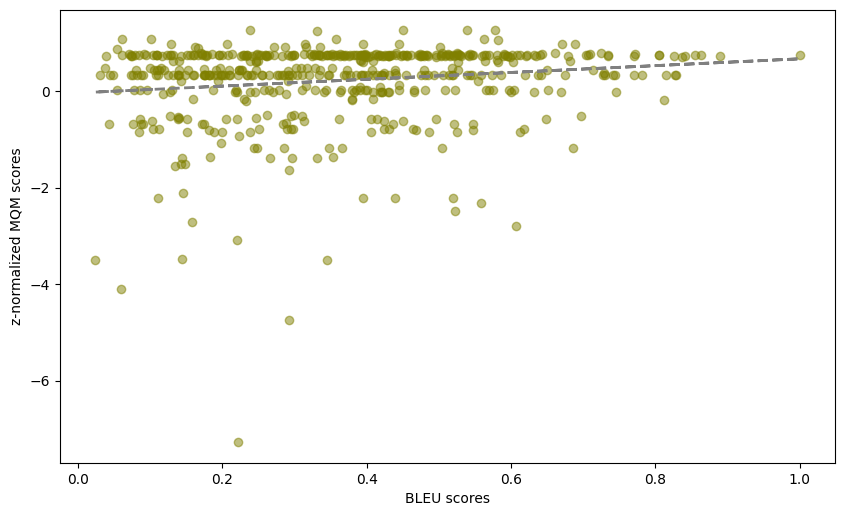

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
# np.random.seed(19680801)

x = metric_scores.sacre_bleu.values
y = metric_scores.z_mqm_score.values
# s = np.random.rand(*x.shape) * 800 + 500

plt.scatter(x, y, c="olive", alpha=0.5, 
#             marker=r'$\clubsuit$',label="Score"
           )
plt.xlabel("BLEU scores")
plt.ylabel("z-normalized MQM scores")

a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b, linestyle='--', linewidth=2, color='gray')

# plt.legend(loc='upper left')
plt.show()

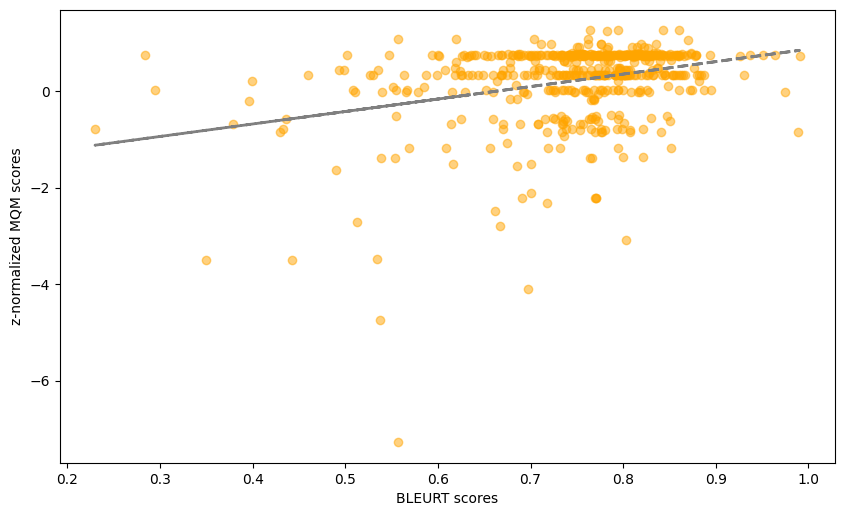

In [43]:
plt.scatter(metric_scores.bleurt.values, metric_scores.z_mqm_score.values, c="orange", alpha=0.5, 
#             marker=r'$\clubsuit$',label="Score"
           )
plt.xlabel("BLEURT scores")
plt.ylabel("z-normalized MQM scores")

x = metric_scores.bleurt.values
y = metric_scores.z_mqm_score.values
a, b = np.polyfit(x, y, 1)

plt.plot(x, a*x+b, linestyle='--', linewidth=2, color='gray')
# plt.legend(loc='upper left')
plt.show()

In [44]:
!pip install seaborn

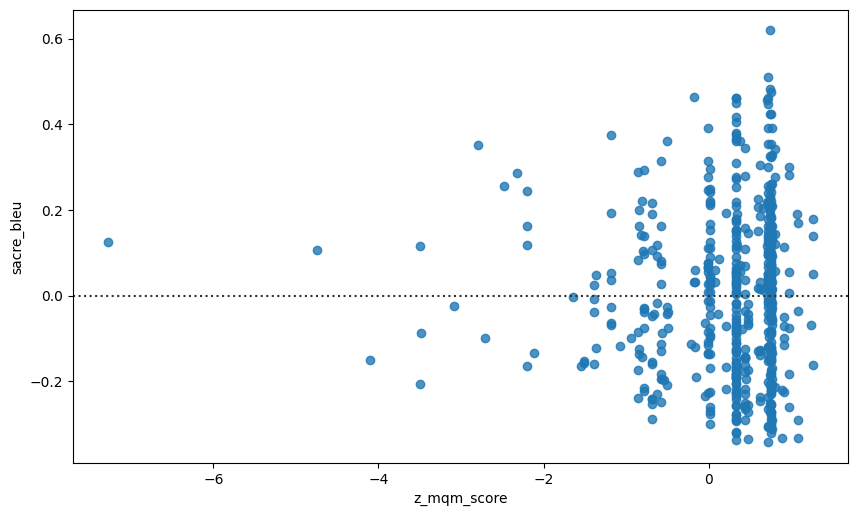

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
  
# reading the csv file  
sns.residplot(x='z_mqm_score', y='sacre_bleu', data=metric_scores)
  
plt.show()

<AxesSubplot:ylabel='Density'>

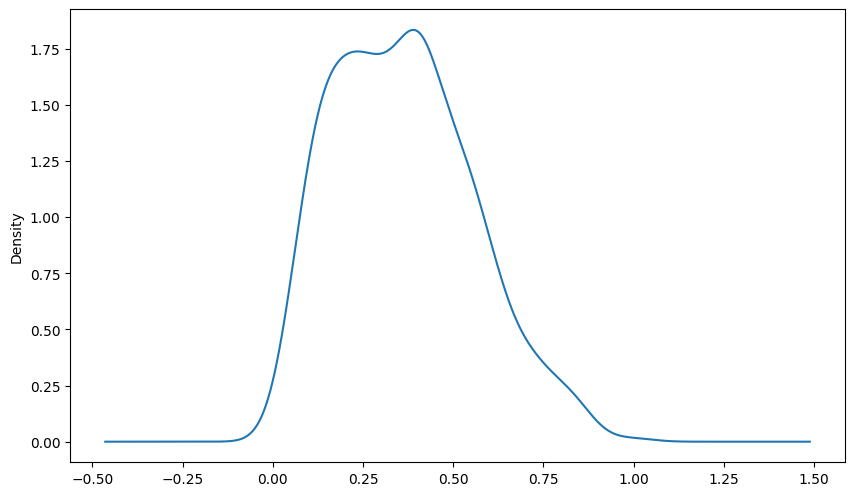

In [46]:
metric_scores.sacre_bleu.plot.kde()
# metric_scores.sacre_bleu.plot.hist()

<AxesSubplot:ylabel='Density'>

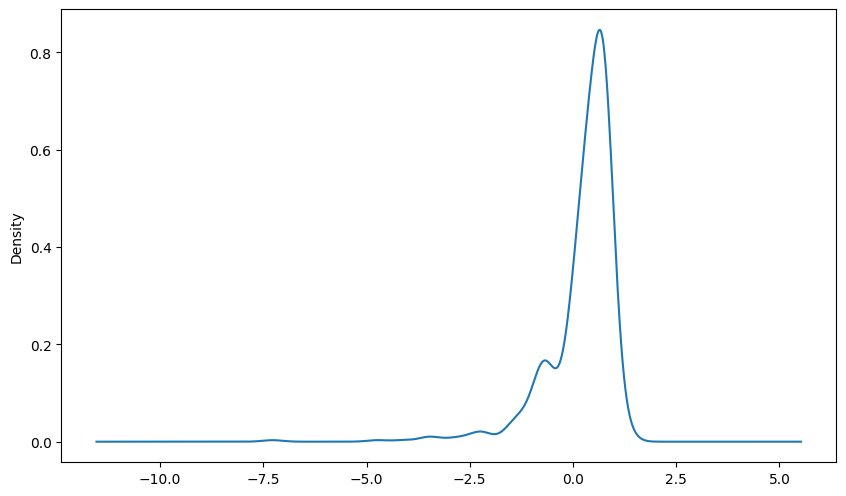

In [47]:
metric_scores.z_mqm_score.plot.kde()
# metric_scores.z_mqm_score.plot.hist()

## Scatterplots of unique scores

In [33]:
preproc_data_path = "../data/wmt21/preprocessed_data/wmt21_preprocessed_full_data.tsv"
full_df = pd.read_csv(preproc_data_path, sep='\t')
full_df

,system_name,seg_id,doc,source,target,rater,mqm_avg_score,category,severity,comment,reference,mt_output,z_mqm_score
0,Facebook-AI,1,rt.com.131279,Couple MACED at California dog park for not we...,"Paar <v>MACED</v> im kalifornischen Hundepark,...",rater2,-5.0,Accuracy/Mistranslation,Major,NaN,Angriff mit Pfefferspray auf ein Paar in einem...,"Paar MACED im kalifornischen Hundepark, weil e...",-0.013807
1,HuaweiTSC,1,rt.com.131279,Couple MACED at California dog park for not we...,"Paar <v>MACED</v> im kalifornischen Hundepark,...",rater4,-5.0,Accuracy/Untranslated,Major,NaN,Angriff mit Pfefferspray auf ein Paar in einem...,"Paar MACED im kalifornischen Hundepark, weil e...",-0.858404
2,Nemo,1,rt.com.131279,Couple MACED at California dog park for not we...,<v>Paar MACED im kalifornischen Hundepark für ...,rater4,-6.0,Style/Awkward,Minor,NaN,Angriff mit Pfefferspray auf ein Paar in einem...,Paar MACED im kalifornischen Hundepark für das...,-1.182732
3,Nemo,1,rt.com.131279,Couple MACED at California dog park for not we...,Paar <v>MACED</v> im kalifornischen Hundepark ...,rater4,-6.0,Accuracy/Untranslated,Major,NaN,Angriff mit Pfefferspray auf ein Paar in einem...,Paar MACED im kalifornischen Hundepark für das...,-1.182732
4,Online-W,1,rt.com.131279,Couple MACED at California dog park for not we...,Paar <v>MACED</v> in Kalifornien Hundepark für...,rater11,-5.0,Accuracy/Mistranslation,Major,NaN,Angriff mit Pfefferspray auf ein Paar in einem...,Paar MACED in Kalifornien Hundepark für nicht ...,-0.561254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,metricsystem1,1002,sky.com.33889,"Wiley, known as the Godfather of Grime and who...","Wiley, bekannt als Godfather of Grime und mit ...",rater9,-2.0,Style/Awkward,Minor,NaN,"Wiley, bekannt als „Godfather of Grime“, desse...","Wiley, bekannt als Godfather of Grime und mit ...",0.342346
8346,metricsystem2,1002,sky.com.33889,"Wiley, known as the Godfather of Grime and who...","Wiley, bekannt als der <v>Pate des Schmutzes <...",rater13,-5.0,Style/Awkward,Major,NaN,"Wiley, bekannt als „Godfather of Grime“, desse...","Wiley, bekannt als der Pate des Schmutzes und ...",0.080083
8347,metricsystem3,1002,sky.com.33889,"Wiley, known as the Godfather of Grime and who...","Wiley, bekannt als Godfather of Grime und mit ...",rater11,-0.0,No-error,No-error,NaN,"Wiley, bekannt als „Godfather of Grime“, desse...","Wiley, bekannt als Godfather of Grime und mit ...",0.709702
8348,metricsystem4,1002,sky.com.33889,"Wiley, known as the Godfather of Grime and who...","Wiley, bekannt als Godfather of Grime und mit ...",rater1,-0.0,No-error,No-error,NaN,"Wiley, bekannt als „Godfather of Grime“, desse...","Wiley, bekannt als Godfather of Grime und mit ...",0.326909


In [37]:
metric_scores['seg_id'] = full_df['seg_id']
metric_scores['mt_system'] = full_df['system_name']

In [55]:
unique_scores_df = metric_scores.drop_duplicates(subset=['seg_id', 'mt_system'])
unique_scores_df.reset_index(inplace=True, drop=True)
unique_scores_sub_df = unique_scores_df.drop(columns=['mt_system', 'seg_id'])

In [59]:
unique_scores_sub_df.corr()

,z_mqm_score,sacre_bleu,sacre_chrf,sacre_ter,bert_xlm-roberta-large_f1,bert_layer_18_xlm-roberta-large_f1,bert_with_idf_xlm-roberta-large_f1,human_score,comet_reg_mqm_21,bleurt,comet_reg_da_20
z_mqm_score,1.000000,0.128547,0.155622,0.157379,0.229690,0.230324,0.226554,1.000000,0.324410,0.350788,0.340881
sacre_bleu,0.128547,1.000000,0.825431,0.851201,0.746118,0.752083,0.728092,0.128547,0.246740,0.546114,0.456350
sacre_chrf,0.155622,0.825431,1.000000,0.762374,0.799771,0.794866,0.834119,0.155622,0.309759,0.608762,0.576794
sacre_ter,0.157379,0.851201,0.762374,1.000000,0.789748,0.797862,0.753790,0.157379,0.267247,0.541950,0.508789
bert_xlm-roberta-large_f1,0.229690,0.746118,0.799771,0.789748,1.000000,0.989810,0.958980,0.229690,0.429646,0.714723,0.683528
bert_layer_18_xlm-roberta-large_f1,0.230324,0.752083,0.794866,0.797862,0.989810,1.000000,0.954460,0.230324,0.437669,0.720283,0.685046
bert_with_idf_xlm-roberta-large_f1,0.226554,0.728092,0.834119,0.753790,0.958980,0.954460,1.000000,0.226554,0.419992,0.712336,0.685963
human_score,1.000000,0.128547,0.155622,0.157379,0.229690,0.230324,0.226554,1.000000,0.324410,0.350788,0.340881
comet_reg_mqm_21,0.324410,0.246740,0.309759,0.267247,0.429646,0.437669,0.419992,0.324410,1.000000,0.667429,0.612291
bleurt,0.350788,0.546114,0.608762,0.541950,0.714723,0.720283,0.712336,0.350788,0.667429,1.000000,0.767397


In [60]:
metric_scores.corr()

,z_mqm_score,sacre_bleu,sacre_chrf,sacre_ter,bert_xlm-roberta-large_f1,bert_layer_18_xlm-roberta-large_f1,bert_with_idf_xlm-roberta-large_f1,human_score,seg_id,comet_reg_mqm_21,bleurt,comet_reg_da_20
z_mqm_score,1.000000,0.152896,0.179027,0.185955,0.267285,0.270434,0.265106,1.000000,0.071531,0.414703,0.409601,0.393155
sacre_bleu,0.152896,1.000000,0.826729,0.829111,0.742709,0.751040,0.725740,0.152896,0.032312,0.251552,0.535004,0.457649
sacre_chrf,0.179027,0.826729,1.000000,0.742083,0.800897,0.798561,0.833957,0.179027,0.078590,0.318233,0.604680,0.573777
sacre_ter,0.185955,0.829111,0.742083,1.000000,0.772001,0.781108,0.737139,0.185955,0.056600,0.264604,0.517133,0.504101
bert_xlm-roberta-large_f1,0.267285,0.742709,0.800897,0.772001,1.000000,0.988814,0.959273,0.267285,0.064347,0.454219,0.721216,0.689874
bert_layer_18_xlm-roberta-large_f1,0.270434,0.751040,0.798561,0.781108,0.988814,1.000000,0.956682,0.270434,0.064731,0.461133,0.727369,0.691912
bert_with_idf_xlm-roberta-large_f1,0.265106,0.725740,0.833957,0.737139,0.959273,0.956682,1.000000,0.265106,0.069573,0.446276,0.722181,0.692113
human_score,1.000000,0.152896,0.179027,0.185955,0.267285,0.270434,0.265106,1.000000,0.071531,0.414703,0.409601,0.393155
seg_id,0.071531,0.032312,0.078590,0.056600,0.064347,0.064731,0.069573,0.071531,1.000000,0.142670,0.153619,0.138462
comet_reg_mqm_21,0.414703,0.251552,0.318233,0.264604,0.454219,0.461133,0.446276,0.414703,0.142670,1.000000,0.689385,0.634041


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='sacre_bleu'>

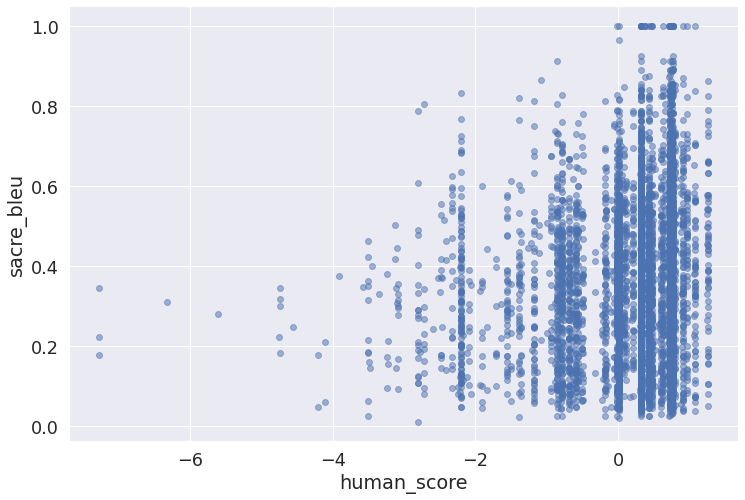

In [40]:
unique_scores_sub_df.plot.scatter(x='human_score', y='sacre_bleu', alpha=0.5, figsize=(12,8), s=35, )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='sacre_chrf'>

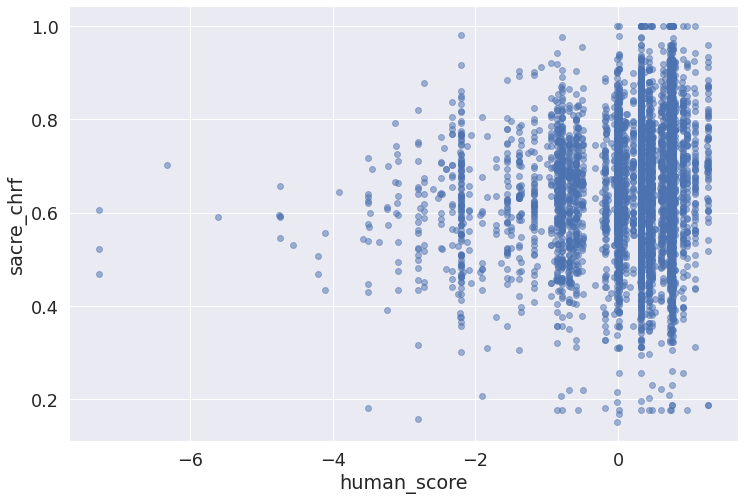

In [41]:
unique_scores_sub_df.plot.scatter(x='human_score', y='sacre_chrf', alpha=0.5, figsize=(12,8), s=35, )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='sacre_ter'>

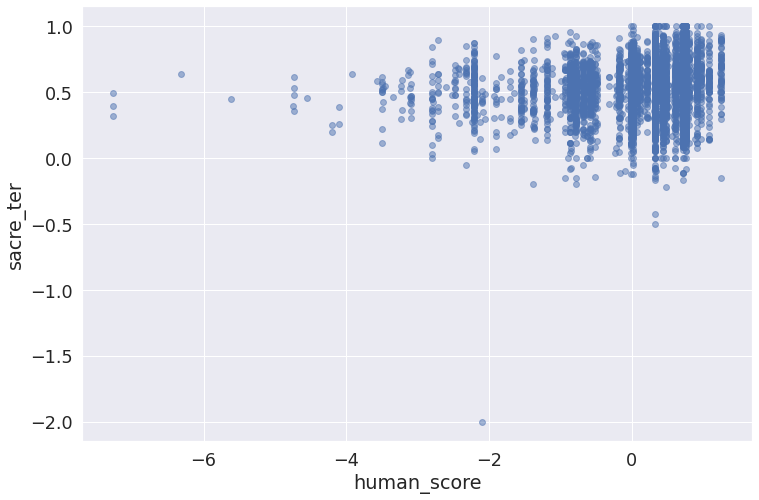

In [42]:
unique_scores_sub_df.plot.scatter(x='human_score', y='sacre_ter', alpha=0.5, figsize=(12,8), s=35, )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='bert_xlm-roberta-large_f1'>

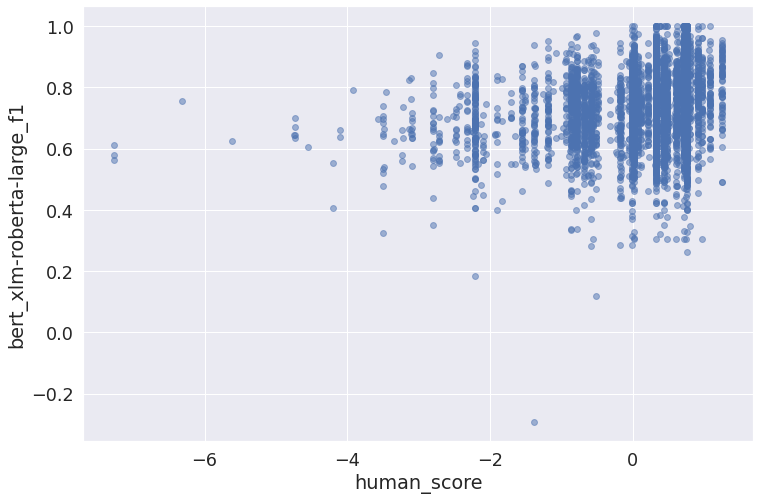

In [43]:
unique_scores_sub_df.plot.scatter(x='human_score', y='bert_xlm-roberta-large_f1', alpha=0.5, figsize=(12,8), s=35, )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='comet_reg_mqm_21'>

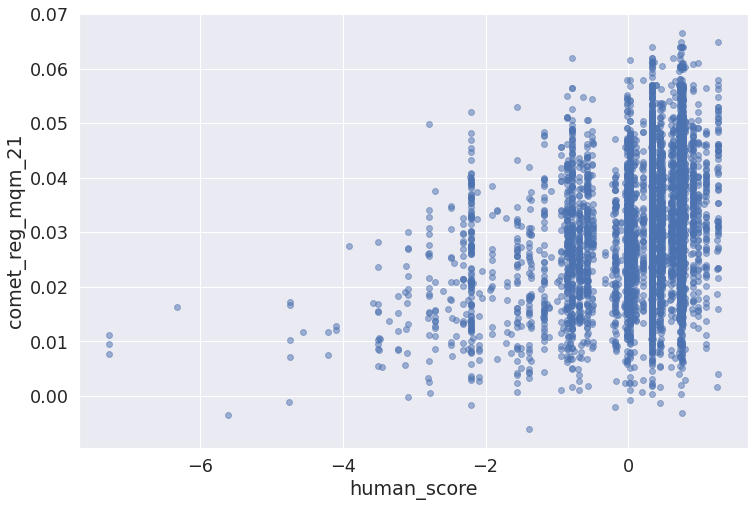

In [52]:
unique_scores_sub_df.plot.scatter(x='human_score', y='comet_reg_mqm_21', alpha=0.5, figsize=(12,8), s=35, )

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_score', ylabel='bleurt'>

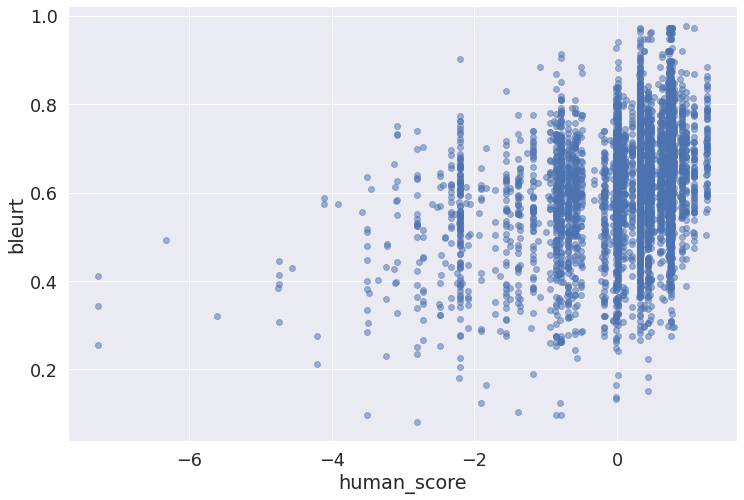

In [53]:
unique_scores_sub_df.plot.scatter(x='human_score', y='bleurt', alpha=0.5, figsize=(12,8), s=35, )